In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, Dropout, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

import pandas as pd

In [2]:
df = pd.read_csv('AIerror_ONU16_15S_Cycle&Ai&Grantold.csv', usecols=[1], engine='python')
df = df.values
df = df.astype('float32')
#df.head()

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [4]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)-18,:]
print(len(train), len(test))

30865 15185


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
# reshape into X=t and Y=t+1
look_back = 16
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)

(30848, 16)
(30848,)
(15168, 16)


In [7]:
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [8]:
# create and fit the LSTM network

#model.add(LSTM(40, input_shape=(1, look_back)))
batch_size = 32
#batch_size = int(len(dataset)/90)

#trainX = tf.data.Dataset.from_tensor_slices((trainX, train_label))
#trainX = trainX.repeat().batch(batch_size, drop_remainder=True)
model = Sequential()

model.add(LSTM(40, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(40, stateful=True, return_sequences=False))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(10):
    model.fit(trainX, trainY,batch_size=batch_size, epochs=1, shuffle=False)
    model.reset_states()
    
#模型評估
trainPredict = model.predict(trainX, batch_size=batch_size)
#reset model
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=1)

964/964 [==============================] - 3s 3ms/step - loss: 0.0011


In [9]:
from sklearn.metrics import mean_squared_error as mse
# make predictions
#trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean absolute error
trainScore2 = math.sqrt(mae(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMAE' % (trainScore2))
testScore2 = math.sqrt(mae(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMAE' % (testScore2))

Train Score: 51757.07 RMSE
Test Score: 330642.18 RMSE
Train Score: 146.51 RMAE
Test Score: 195.72 RMAE


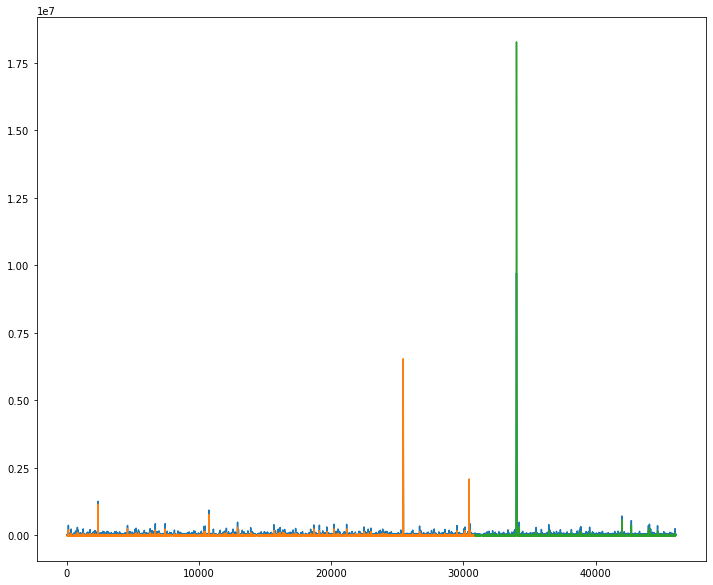

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-19, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(12, 10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 16, 40)              6720      
_________________________________________________________________
lstm_1 (LSTM)                (32, 40)                  12960     
_________________________________________________________________
dense (Dense)                (32, 1)                   41        
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [12]:
from sklearn.metrics import r2_score
train_Y = trainY.T
print(r2_score(train_Y, trainPredict))

0.7985012762439961
